# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки.

**План 3 недели:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [166]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
import datetime
import operator
from itertools import combinations
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [167]:
def diff_for_date(a):
    if a.size < 2:
        return []
    else:
        return list(map(int, list(map(datetime.timedelta.total_seconds, np.diff(a).tolist()))))

In [168]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names, session_length=10, window_width=10):
    
    # Получаем список файлов, удовлетворяющих заданной маске
    list_of_files = glob(csv_files_mask)
    data = []
    
    # Feature engineering
    time_diff_list = []
    min_time = 0
    max_time = 0
    unique_sites = {}
    
    # Reading site dictionary
    with open(site_freq_path, "rb") as fp:
        site_dict = pickle.load(fp)
        
    # Reading data files
    for path in list_of_files:
        all_sites_from_file = []
        all_times_from_file = []
        # Читаем файлы из списка
        with open(path, 'r') as filep:
            lines = filep.readlines()[1:]
            list_of_sites = []
            for line in lines:
                # Читаем строки из файла, каждую строку разбиваем на части
                list_of_tokens = line.strip().split(',')
                # Проверяем, что строка не пустая
                if len(list_of_tokens) != 2:
                    break
                # Добавляем элемент в словарь
                all_sites_from_file.append(site_dict[list_of_tokens[1]][0])
                all_times_from_file.append(list_of_tokens[0])
                user_id = int(path[-8:-4])
        n = len(all_sites_from_file)
        
        ind = 0
        while True:
            if ind + session_length > n-1:
                a = np.array(all_times_from_file[ind:n], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a) + [0 for _ in range(session_length - n + ind)]
                min_time = a.min()
                data.append(sites + [0 for _ in range(session_length - n + ind)] + 
                            time_diff +
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] +
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            else:
                a = np.array(all_times_from_file[ind:ind+session_length], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a)
                min_time = a.min()
                data.append(sites + 
                            time_diff + 
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] + 
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            ind += window_width
            if ind >= n:
                break
    df = pd.DataFrame(data,columns = feature_names)
    return df.drop_duplicates()

**Проверим функцию на игрушечном примере.**

In [169]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
        
train_data_toy  = prepare_train_set_with_fe('capstone_user_identification/3users/*', 
                                   site_freq_path='capstone_user_identification/site_freq_3users.pkl',
                                   feature_names=feature_names, session_length=10)

In [170]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [171]:
%%time
train_data_10users = prepare_train_set_with_fe('capstone_user_identification/10users/*', 
                                               site_freq_path='capstone_user_identification/site_freq_10users.pkl',
                                               feature_names=feature_names, session_length=10)

Wall time: 5.59 s


In [172]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,2,3,4,5,4,4,5,4,6,4,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,7,8,9,10,4,11,12,13,14,15,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,15,5,15,15,16,17,7,18,19,15,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,20,21,20,15,15,15,15,22,23,24,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,25,15,16,26,27,28,29,30,31,30,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [173]:
%%time
train_data_150users = prepare_train_set_with_fe('capstone_user_identification/150users/*', 
                                               site_freq_path='capstone_user_identification/site_freq_150users.pkl',
                                               feature_names=feature_names, session_length=10)

Wall time: 44.4 s


**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [174]:
new_features = ['time_diff' + str(j) for j in range(1,10)] + \
               ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [175]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [176]:
with open('capstone_user_identification/new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
    
with open('capstone_user_identification/new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [177]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [178]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [179]:
matplotlib.rc('font', family='Arial')

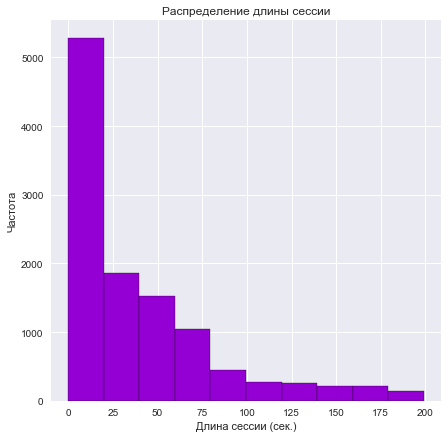

In [180]:
fig, ax = plt.subplots()
timespan = train_data_10users.session_timespan
train_data_10users[timespan < 200]['session_timespan'].plot(kind='hist', 
                                                            color='darkviolet', ax=ax, figsize = (7,7),
                                                            edgecolor='black')
ax.set_xlabel(u'Длина сессии (сек.)')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение длины сессии');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

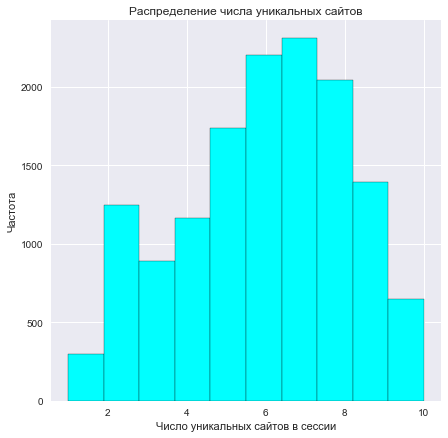

In [181]:
fig, ax = plt.subplots()
train_data_10users['#unique_sites'].plot(kind='hist', ax=ax, color='aqua', figsize = (7,7), edgecolor='black')
ax.set_xlabel(u'Число уникальных сайтов в сессии')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение числа уникальных сайтов');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

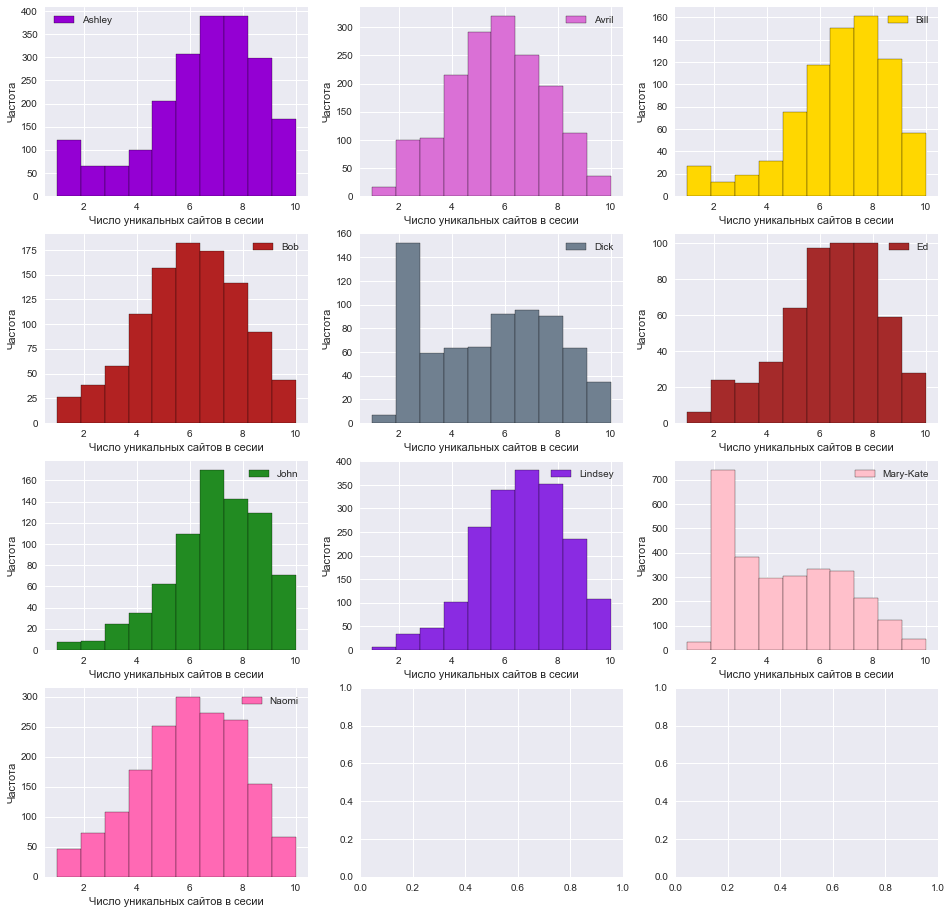

In [182]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['#unique_sites'].plot(kind='hist',
                                 ax=axes[idx/3, idx%3], 
                                 color=color_dic[user], 
                                 legend=True,
                                 edgecolor='black'
                                )
    axes[idx/3, idx%3].set_xlabel(u'Число уникальных сайтов в сесии')
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

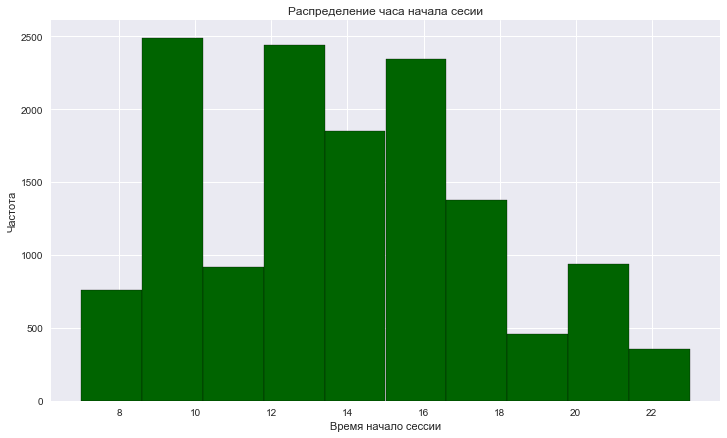

In [183]:
fig, ax = plt.subplots()
train_data_10users['start_hour'].plot(kind='hist', 
                                      color='darkgreen',
                                      ax=ax,
                                      edgecolor='black',
                                      figsize = (12,7)
                                     )
ax.set_xlabel(u'Время начало сессии')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение часа начала сесии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

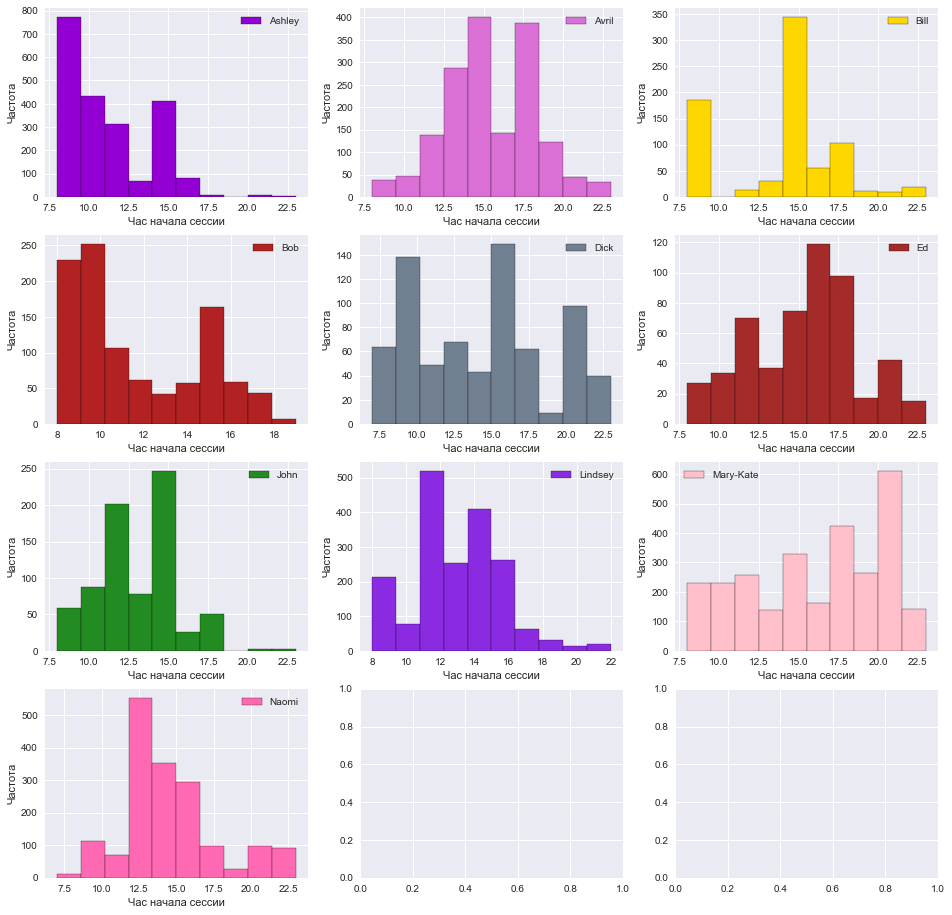

In [184]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['start_hour'].plot(kind='hist',
                              ax=axes[idx/3, idx%3],
                              color=color_dic[user],
                              legend=True,
                              bins=10,
                              edgecolor='black'
                             )
    axes[idx/3, idx%3].set_xlabel(u'Час начала сессии')
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

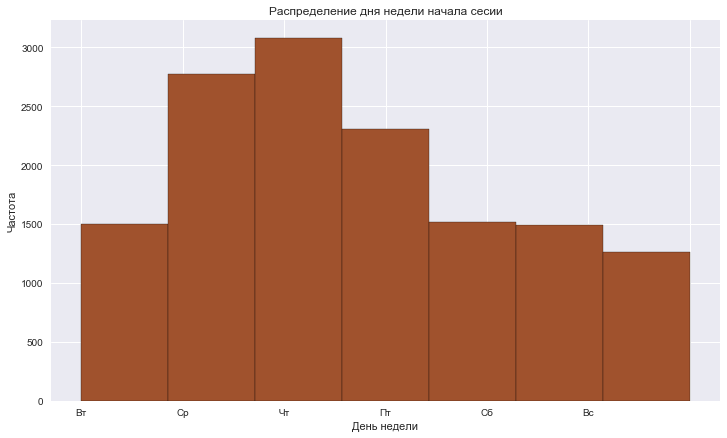

In [185]:
fig, ax = plt.subplots()
train_data_10users['day_of_week'].plot(kind='hist',
                                       ax=ax,
                                       color='sienna',
                                       bins=7,
                                       edgecolor='black',
                                       figsize = (12,7)
                                      )
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Частота')
ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
ax.set_title(u'Распределение дня недели начала сесии');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

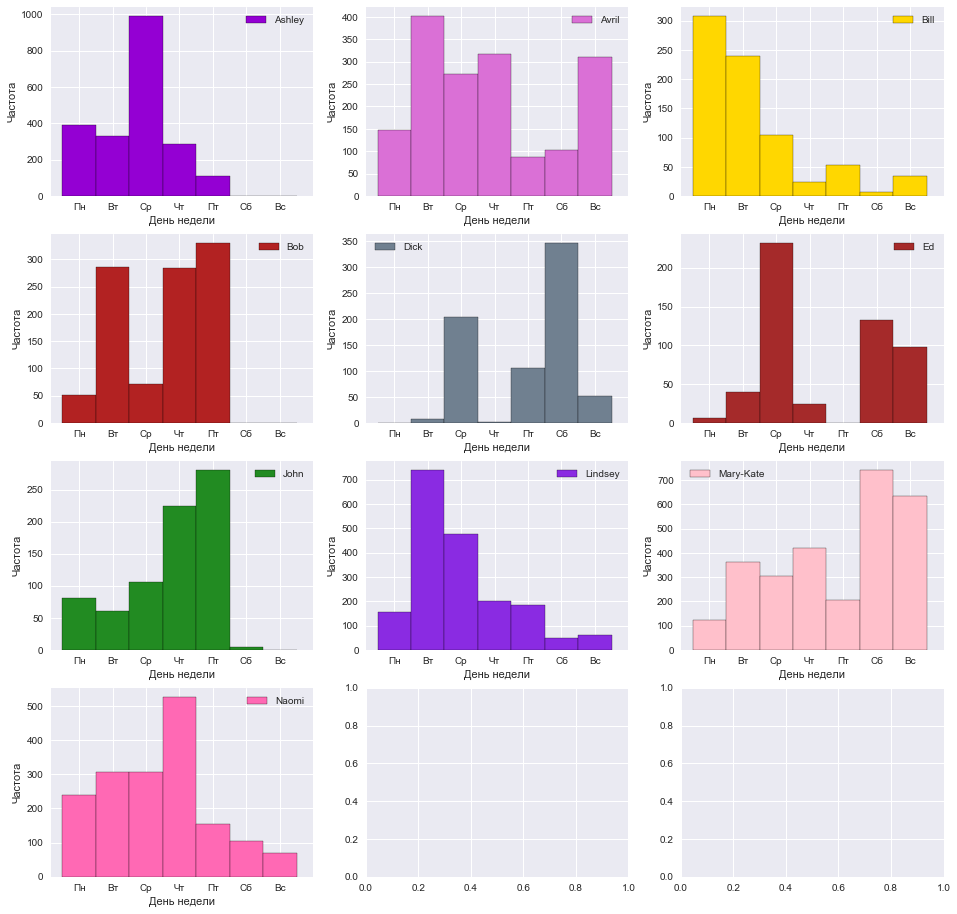

In [186]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['day_of_week'].plot(kind='hist', 
                               ax=axes[idx/3, idx%3], 
                               color=color_dic[user],
                               legend=True,
#                                bins = 7,
                               bins=np.arange(-0.5,7,1),
                               xticks=range(8),
                               edgecolor='black'
                              )
    axes[idx/3, idx%3].set_xlabel(u'День недели')
    axes[idx/3, idx%3].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

**8. Выводы. **

1. Ashley на выходных не выходит в сеть, пик активности - среда. В основном посещает сайты в утренние часы. Любит сидеть на одном сайте, либо немного серфит интернет.
2. Avril чаще заходит в интернет в вт, ср, чт, вс. Сидит на разных сайтах - распределение нормальное. Зависает в интернете днем и ближе к вечеру.
3. Bill чаще бывает в интернете в понедельник и вторник. Пик активности раннее утро и день. Посещает разные сайты - распределение похоже на нормальное.
4. Bob не чаще всего бывает в вт, чт, пт, не бывает в выходные дни. Пик активности - утро. Посещает разные сайты -распределение похоже на нормальное.
5. Dick в основном засиживается в интернете в субботу и ср. Активность проявляет в разное время: и утром, и днем, и вечером. Любит засиживаться на одном-двух сайтах. 
6. Ed засиживается в интернете на выходных и в среду. Пик активности приходится на день. Посещает разные сайты - распределение похоже на нормальное.
7. John в основном выходит в интернете в чт и пт. Пик активности - утро и день. Посещает разные сайты - распределение похоже на нормальное.
8. Lindsey в основном проводит время в интеренте по вторникам. Наиболее активна утром и днем. Посещает разные сайты -распределение похоже на нормальное.
9. Mary-Kate проявляет наибольшую активность в выходные дни. Пик дневной активности приходится на вечер.  Любит засиживаться на одном-двух сайтах. 
10. Naomi выходит в интернет в основном с пн по чт, чт - пик.  Наибольшую активность проявляет в начале дня. Посещает разные сайты - распределение похоже на нормальное.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [187]:
with open("capstone_user_identification/site_freq_10users.pkl", "rb") as fid:
    site_freq_10 = pickle.load(fid)

In [188]:
def itemgetter_own(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item][1]
    return g

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [189]:
top_10 = sorted(site_freq_10.items(), key=itemgetter_own(1), reverse=True)[:10]

In [190]:
top_10

[('www.google.fr', (52, 7796)),
 ('s.youtube.com', (211, 6576)),
 ('www.google.com', (5, 5068)),
 ('mail.google.com', (184, 4082)),
 ('www.facebook.com', (16, 4071)),
 ('apis.google.com', (53, 3756)),
 ('plus.google.com', (188, 2611)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (215, 2198)),
 ('accounts.google.com', (185, 2087)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (701, 2014))]

In [191]:
top10_freqs = [freq for _, (ind, freq) in top_10]
top10_sites = [site for site, _ in top_10]

In [192]:
print(list(zip(top10_sites, top10_freqs)))

[('www.google.fr', 7796), ('s.youtube.com', 6576), ('www.google.com', 5068), ('mail.google.com', 4082), ('www.facebook.com', 4071), ('apis.google.com', 3756), ('plus.google.com', 2611), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 2198), ('accounts.google.com', 2087), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 2014)]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

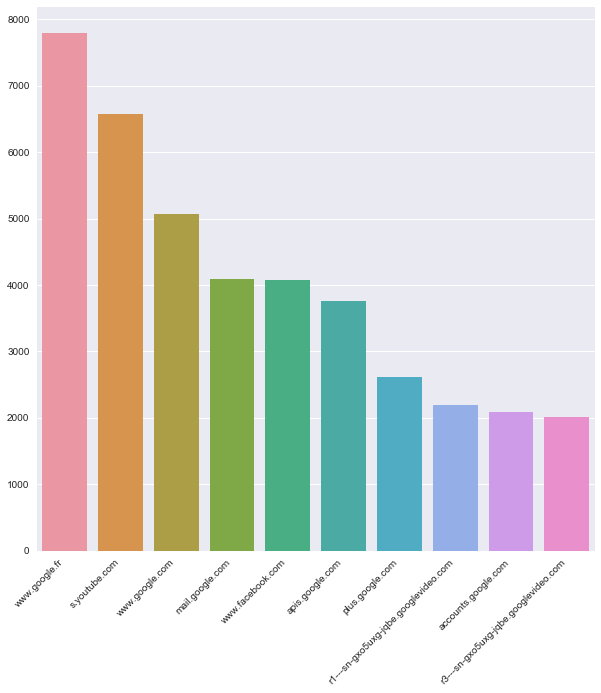

In [193]:
plt.rcParams['figure.figsize']=(10,10)
barblot = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=45, horizontalalignment='right');

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

1. рассмотрим базовые признаки, как логарифм сессии, а так же среднее время нахождения на сайте(тоже логарифм)
2. В дополнение к дням недели - время суток(из анализа дневной активности 10 пользователей), отдельно выходные
3. Короткое посещение сайта

In [198]:
def feature_engineering(df_data):
    df_new_data = df_data.copy()
    df_new_data['log_session'] = df_new_data['session_timespan'].apply(lambda x: np.log(x + 1))
    df_new_data['log_sess_ts_avg'] = df_new_data['log_session']/df_new_data['#unique_sites']
    df_new_data['morning'] = df_new_data['start_hour'].apply(lambda x: int(6 <= x and x < 12))
    df_new_data['afternoon'] = df_new_data['start_hour'].apply(lambda x: int(12 <= x and x < 18))
    df_new_data['evening'] = df_new_data['start_hour'].apply(lambda x: int(18 <= x and x < 24))
    df_new_data['night'] = df_new_data['start_hour'].apply(lambda x: int(0 <= x and x < 6))
    df_new_data['weekend'] = df_new_data['day_of_week'].apply(lambda x: int(x >= 5))
    time_diff_list = ['time_diff' + str(i) for i in range(1,10)]
    df_new_data['low_time_diff'] = (df_new_data[time_diff_list].apply(np.abs) < 2).sum(axis = 1)
    
    new_features_list = ['log_session', 'log_sess_ts_avg', 'morning',
                        'afternoon', 'evening', 'night', 'weekend', 'low_time_diff']
    
    for (i, j) in combinations(['site' + str(i) for i in range(1, 11)], 2):
        df_new_data[i + "#" + j] = df_new_data[i].apply(str) + "#" + df_new_data[j].apply(str)
        
        new_features_list.append(i + "#" + j)
    return df_new_data[new_features_list]

In [199]:
%%time
new_features_10users = feature_engineering(train_data_10users)

Wall time: 3.33 s


In [200]:
%%time
new_features_150users = feature_engineering(train_data_150users)

Wall time: 21.6 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

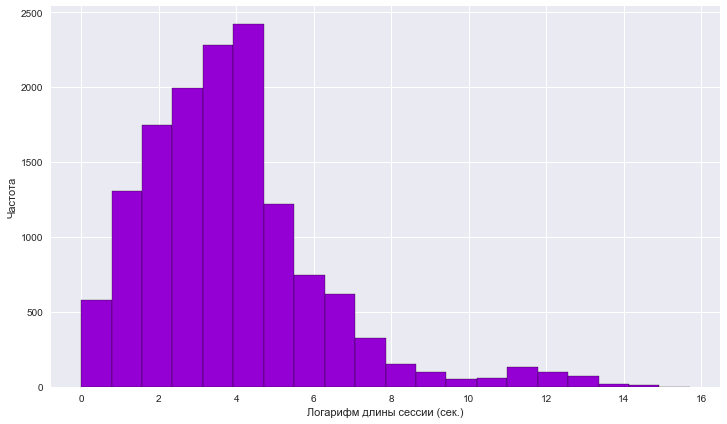

In [201]:
fig, ax = plt.subplots()
new_features_10users['log_session'].plot(kind='hist',
                                                  color='darkviolet',
                                                  ax=ax, 
                                                  edgecolor='black',
                                                  figsize = (12,7),
                                                  bins = 20)
ax.set_xlabel(u'Логарифм длины сессии (сек.)')
ax.set_ylabel(u'Частота')

In [202]:
all_columns = pd.concat([new_features_10users, train_data_10users['target']], axis=1)

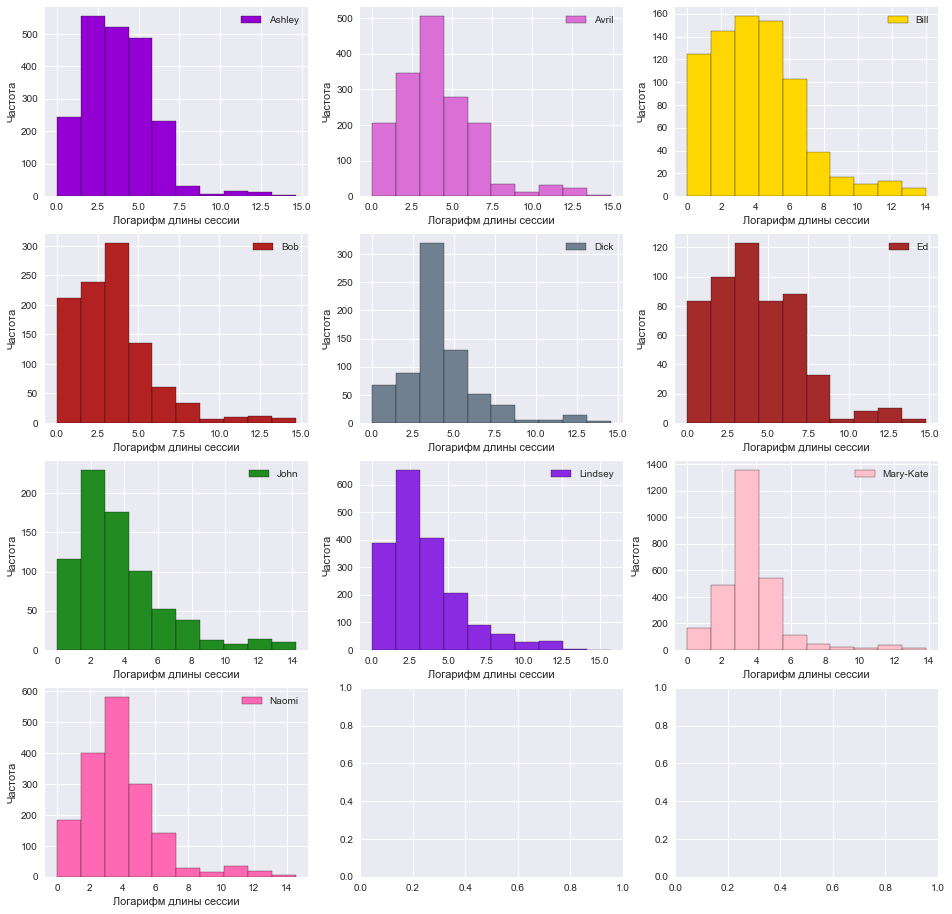

In [203]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for idx, (user, sub_df) in  enumerate(pd.groupby(all_columns, 'target')): 
    sub_df['log_session'].plot(kind='hist',
                                        ax=axes[idx/3, idx%3],
                                        color=color_dic[user],
                                        edgecolor='black',
                                        legend=True,
                                        bins=10)
    axes[idx/3, idx%3].set_xlabel(u'Логарифм длины сессии')
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

По этому признаку можем выделить несколько групп пользователей: Dick, Mary-Kate, Naomi; John, Lindsey, Bob, Avril; 
все остальные. Таким образом, данный признак позволяет отличить некоторых пользователей.

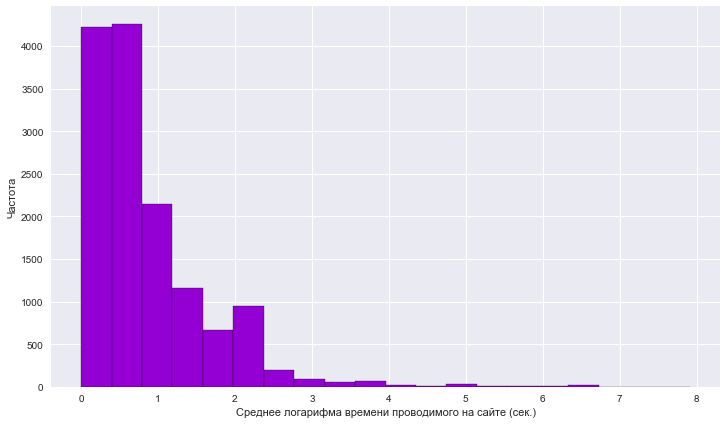

In [204]:
fig, ax = plt.subplots()
new_features_10users['log_sess_ts_avg'].plot(kind='hist',
                                             color='darkviolet', 
                                             ax=ax,
                                             bins = 20,
                                             edgecolor='black',
                                             figsize = (12,7)
                                            )
ax.set_xlabel(u'Среднее логарифма времени проводимого на сайте (сек.)')
ax.set_ylabel(u'Частота')

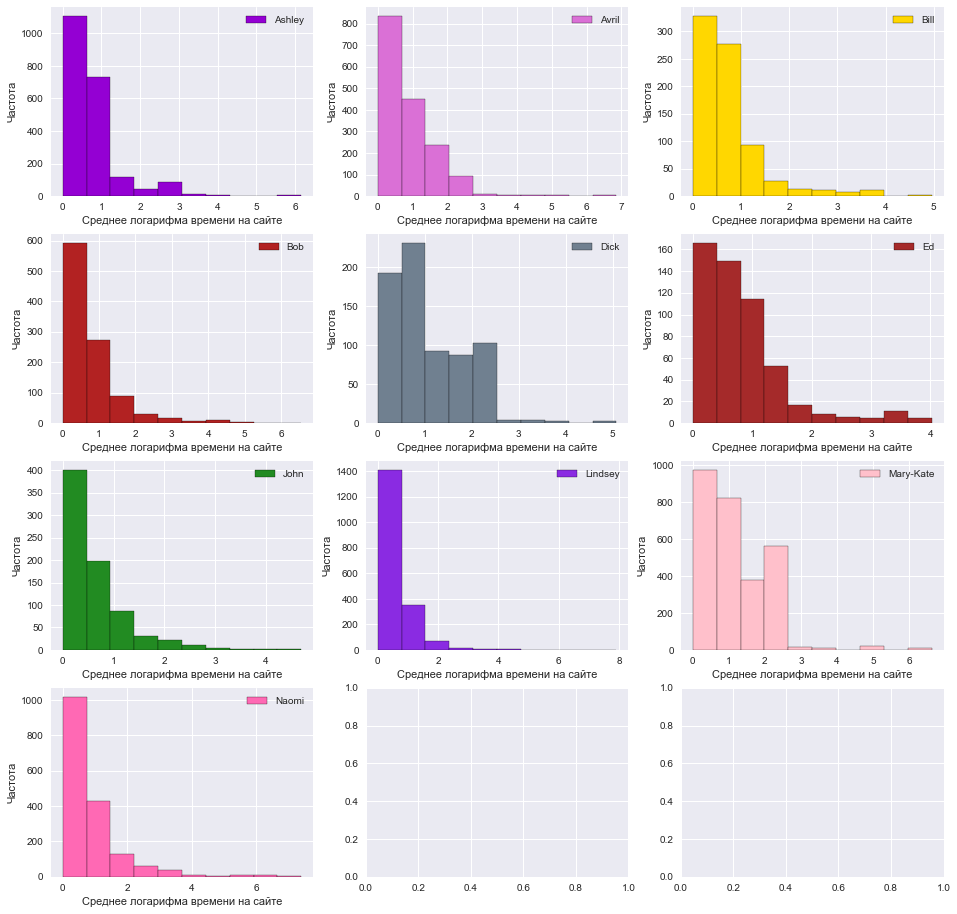

In [205]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for idx, (user, sub_df) in  enumerate(pd.groupby(all_columns, 'target')): 
    sub_df['log_sess_ts_avg'].plot(kind='hist',
                                        ax=axes[idx/3, idx%3],
                                        color=color_dic[user],
                                        edgecolor='black',
                                        legend=True,
                                        bins=10)
    axes[idx/3, idx%3].set_xlabel(u'Среднее логарифма времени на сайте')
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

Видим, что есть различные виды распределений данного признака, т.е. его тоже можно использовать для идентификации пользователей.

Рассмотрим теперь индикаторы утра и т.д. и индикатор выходных.

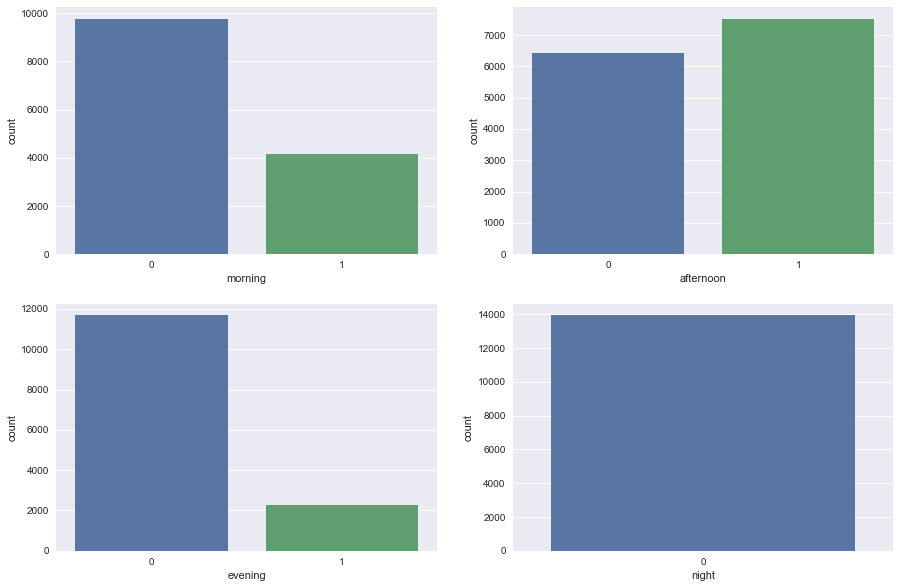

In [206]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.countplot(new_features_10users['morning'], ax=ax[0,0])
sns.countplot(new_features_10users['afternoon'], ax=ax[0,1])
sns.countplot(new_features_10users['evening'], ax=ax[1,0])
sns.countplot(new_features_10users['night'], ax=ax[1,1])

Кроме ночи можно оставитьв се признаки.

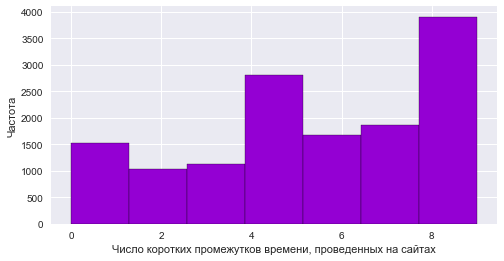

In [207]:
fig, ax = plt.subplots(figsize=(8,4))
new_features_10users['low_time_diff'].plot(kind='hist', 
                                           color='darkviolet',
                                           ax=ax, 
                                           bins = 7,
                                           edgecolor='black'
                                          )
ax.set_xlabel(u'Число коротких промежутков времени, проведенных на сайтах')
ax.set_ylabel(u'Частота')

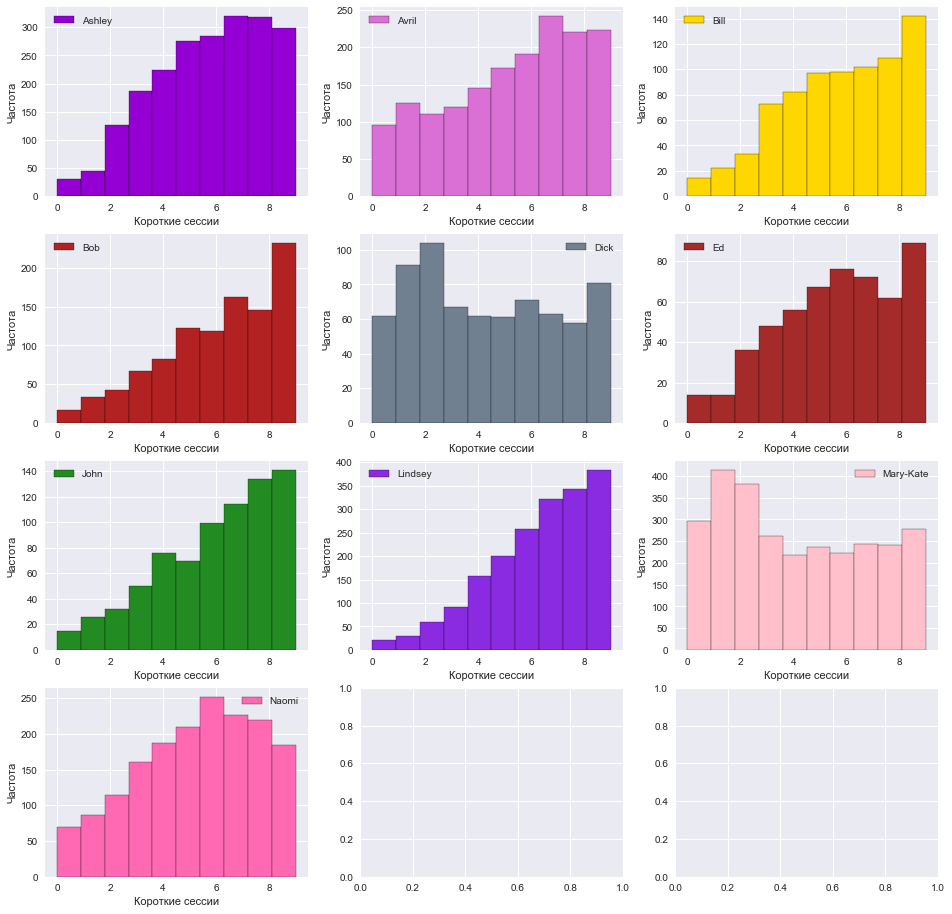

In [208]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))


for idx, (user, sub_df) in  enumerate(pd.groupby(all_columns, 'target')): 
    sub_df['low_time_diff'].plot(kind='hist',
                                 ax=axes[idx/3, idx%3], 
                                 color=color_dic[user],
                                 legend=True,
                                 edgecolor='black',
                                 bins=10)
    axes[idx/3, idx%3].set_xlabel(u'Короткие сессии')
    axes[idx/3, idx%3].set_ylabel(u'Частота')
    axes[idx/3, idx%3].legend([user])

Этот признак также является полезным в различении пользователей

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [209]:
features_list = ['site' + str(i) for i in range(1, 11)] + \
                ['time_diff' + str(i) for i in range(1,10)] + ['#unique_sites', 'start_hour', 'day_of_week']

In [210]:
selected_features_10users = pd.concat([train_data_10users[features_list], new_features_10users.drop('night',axis=1)],axis=1)
selected_features_150users=pd.concat([train_data_150users[features_list],new_features_150users.drop('night',axis=1)],axis=1) 

In [211]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)